## SETUP

In [1]:
# Required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [3]:
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import load_dataset

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score
)

In [4]:
# seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


In [5]:
# Checking GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-40GB


## DATA LOADING

In [6]:
# Load dataset from HuggingFace
dataset = load_dataset("facebook/anli")

In [7]:
# Extract Round 2 splits
train_data = dataset['train_r2']
dev_data = dataset['dev_r2']
test_data = dataset['test_r2']

In [8]:
print(f"Training examples: {len(train_data):,}")
print(f"Validation examples: {len(dev_data):,}")
print(f"Test examples: {len(test_data):,}")

Training examples: 45,460
Validation examples: 1,000
Test examples: 1,000


In [9]:
# Convert to DataFrames
train_df = pd.DataFrame(train_data)
dev_df = pd.DataFrame(dev_data)
test_df = pd.DataFrame(test_data)

In [10]:
train_df.head(5)

,uid,premise,hypothesis,label,reason
0,245475c4-6225-4f5c-b945-e13e0e988fc8,Topi Raja Sweety Roja is a 1996 Telugu comedy ...,The lead role was played by Rajendra Prasad,0,
1,5837ee91-4527-45b7-bd03-5f0a495d71af,Idris Sultan (born January 1993) is a Tanzania...,Idris Sultan was born in Tanzania.,0,
2,ed5c37ab-77c5-4dbc-ba75-8fd617b19712,Idris Sultan (born January 1993) is a Tanzania...,Idris Sultan was born in the first month of th...,0,
3,0b54db09-9ce9-4915-91cf-6e8cc2264ae7,Nantwich Town Football Club is a semi-professi...,Nantwich Town Football Club is a professional ...,2,
4,55b3a9b0-6b5c-4fd6-a964-04156b3f574d,Nantwich Town Football Club is a semi-professi...,Nantwich Town Football plays in the Championsh...,2,


In [11]:
dev_df.head(5)

,uid,premise,hypothesis,label,reason
0,4145fcb6-de26-4910-a4f0-64275c50f2be,Clear Hearts Grey Flowers is the second full-l...,Risk Records released Jack Off Jill's initial ...,1,"The second album was released by Risk Records,..."
1,bd0c2c0e-1b32-4f55-84f9-ea62737624fd,"Joseph Byron Stannard (February 6, 1872 – Febr...",Joseph Byron Stannard was soldier in World War...,1,The context statement makes no mention of whet...
2,563b895e-cc7d-48a9-8281-937b8c49d577,Babes in Arms is a 1937 musical comedy with mu...,Babes in Arms is a musical comedy that was rel...,2,It is now 2019 and if the musical came out in ...
3,7003d36c-b062-41d2-9051-9636b3c3be82,The Washington Nationals are a professional ba...,The Washington Nationals have played in Nation...,0,"They've played there since the 2008 season, wh..."
4,8ecb7c13-dbd6-4def-92fb-ad135e3cfbc2,The Local Government (Northern Ireland) Act 19...,the Local Government (Boundaries) Act (Norther...,1,The Local Government (Northern Ireland) Act 19...


In [12]:
test_df.head(5)

,uid,premise,hypothesis,label,reason
0,7165747b-c5c7-400f-952d-b65d0169fa3a,There is a little Shia community in El Salvado...,The community is south of the United States.,0,The community is in El Salvador which is south...
1,27a054fa-cd64-4925-bcf5-e8406114ac35,"""Look at Me (When I Rock Wichoo)"" is a song by...",The song was released in America in September ...,1,It doesn't state if it was released anywhere o...
2,c424bba3-26dd-48fb-abf7-62eedac7910c,"""Eternally"" is a song with music by Charles Ch...",The words to Eternally were written partially ...,0,This is correct because it says him and anothe...
3,27bd6e54-e9da-4abc-a7e8-075d73cd1c68,"Louis S. Peterson (June 17, 1922 – April 27, 1...",Louis S. Peterson was an adult when he wrote h...,1,The article does not state his age. Unsure why...
4,fc439129-505b-48cc-8f17-a7b2ccddacdd,Things Happen at Night is a 1947 British super...,Frank Harvey Jnr. wrote Things Happen at Night .,2,"It is based off of the play, but he did not ac..."


## EXPLORATORY DATA ANALYSIS

In [13]:
# Label mapping
label_map = {0: 'entailment', 1: 'neutral', 2: 'contradiction'}
reverse_label_map = {v: k for k, v in label_map.items()}

In [14]:
# Class distribution
train_dist = train_df['label'].value_counts().sort_index()
for idx, count in train_dist.items():
    pct = (count / len(train_df)) * 100
    print(f"{label_map[idx].capitalize():15} {count:6,} ({pct:5.2f}%)")

Entailment      14,448 (31.78%)
Neutral         20,959 (46.10%)
Contradiction   10,053 (22.11%)


In [15]:
# Text length analysis
train_df['premise_len'] = train_df['premise'].str.split().str.len()
train_df['hypothesis_len'] = train_df['hypothesis'].str.split().str.len()

In [16]:
print("\nPremise length (words):")
print(train_df['premise_len'].describe())


Premise length (words):
count    45460.000000
mean        53.997800
std          8.163158
min         33.000000
25%         47.000000
50%         54.000000
75%         60.000000
max         76.000000
Name: premise_len, dtype: float64


In [17]:
print("\nHypothesis length (words):")
print(train_df['hypothesis_len'].describe())


Hypothesis length (words):
count    45460.000000
mean         9.952178
std          5.335210
min          3.000000
25%          7.000000
50%          9.000000
75%         11.000000
max         65.000000
Name: hypothesis_len, dtype: float64


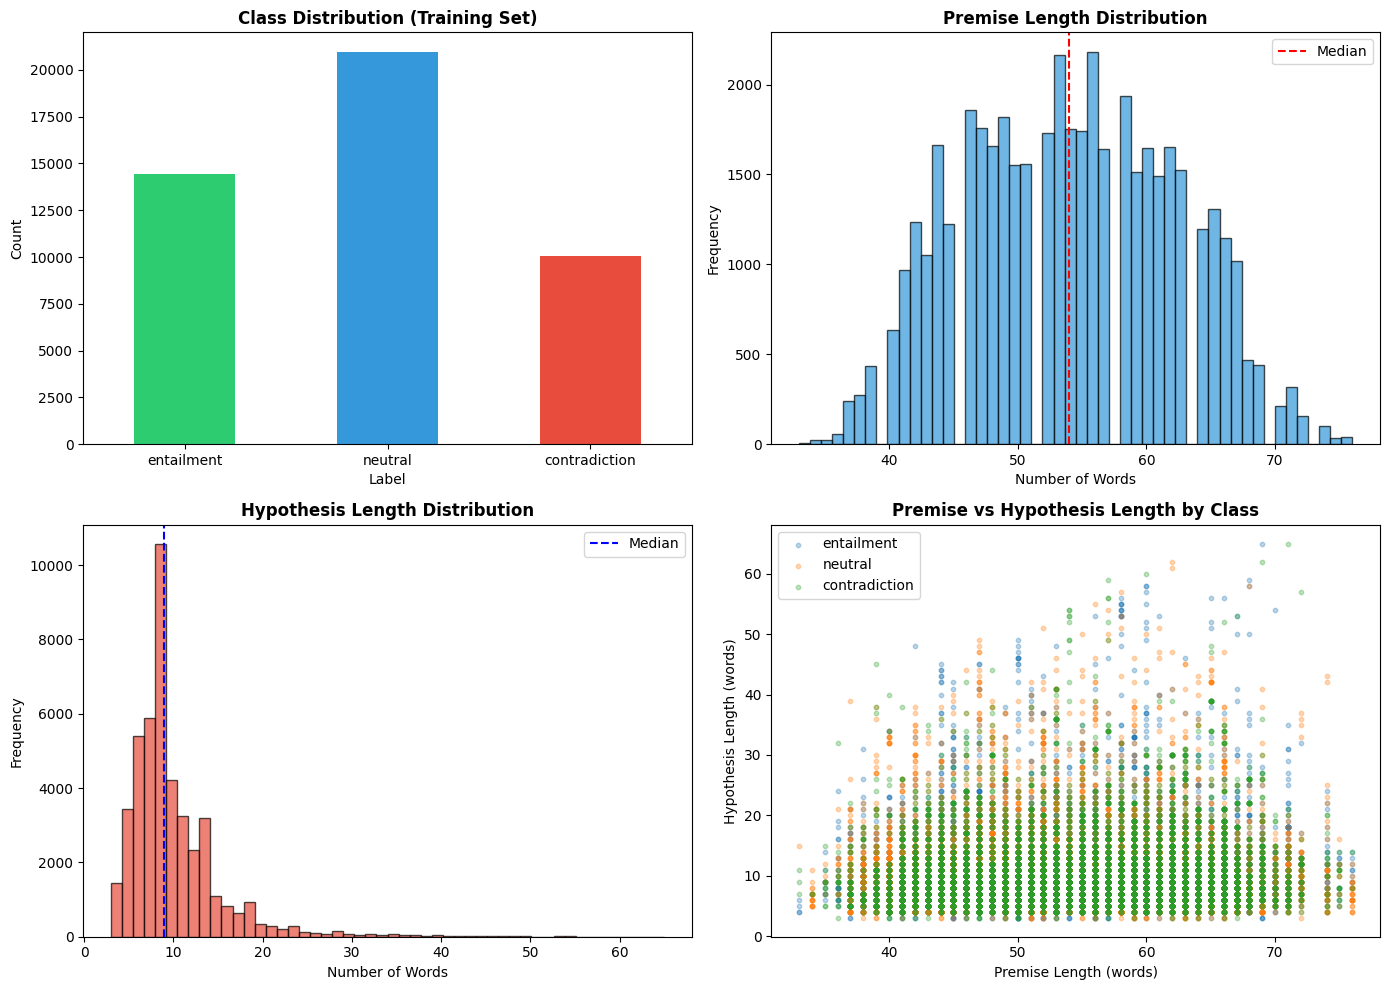

In [18]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Class distribution
ax1 = axes[0, 0]
train_dist.plot(kind='bar', ax=ax1, color=['#2ecc71', '#3498db', '#e74c3c'])
ax1.set_title('Class Distribution (Training Set)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
ax1.set_xticklabels([label_map[i] for i in range(3)], rotation=0)

# Premise length distribution
ax2 = axes[0, 1]
ax2.hist(train_df['premise_len'], bins=50, alpha=0.7, color='#3498db', edgecolor='black')
ax2.set_title('Premise Length Distribution', fontsize=12, fontweight='bold')
ax2.set_xlabel('Number of Words')
ax2.set_ylabel('Frequency')
ax2.axvline(train_df['premise_len'].median(), color='red', linestyle='--', label='Median')
ax2.legend()

# Hypothesis length distribution
ax3 = axes[1, 0]
ax3.hist(train_df['hypothesis_len'], bins=50, alpha=0.7, color='#e74c3c', edgecolor='black')
ax3.set_title('Hypothesis Length Distribution', fontsize=12, fontweight='bold')
ax3.set_xlabel('Number of Words')
ax3.set_ylabel('Frequency')
ax3.axvline(train_df['hypothesis_len'].median(), color='blue', linestyle='--', label='Median')
ax3.legend()

# Length by class
ax4 = axes[1, 1]
for label in [0, 1, 2]:
    subset = train_df[train_df['label'] == label]
    ax4.scatter(subset['premise_len'], subset['hypothesis_len'], 
                alpha=0.3, label=label_map[label], s=10)
ax4.set_title('Premise vs Hypothesis Length by Class', fontsize=12, fontweight='bold')
ax4.set_xlabel('Premise Length (words)')
ax4.set_ylabel('Hypothesis Length (words)')
ax4.legend()

plt.tight_layout()
plt.show()


In [19]:
plt.savefig('./visualizations_TF/eda_visualizations.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [20]:
# Displaying eample for each category
for label in [0, 1, 2]:
    sample = train_df[train_df['label'] == label].iloc[0]
    print(f"\n{label_map[label].upper()}:")
    print(f"Premise: {sample['premise']}")
    print(f"Hypothesis: {sample['hypothesis']}")


ENTAILMENT:
Premise: Topi Raja Sweety Roja is a 1996 Telugu comedy film, produced by Dr. A. Vijayalakshmi on Sri Sai Madhavi Productions banner and directed by Dr. N. Siva Prasad. Starring Rajendra Prasad, Roja in the lead roles and music also composed by "Hero" Rajendra Prasad.
Hypothesis: The lead role was played by Rajendra Prasad

NEUTRAL:
Premise: Have a Little Faith is a Hallmark Hall of Fame television movie. The film debuted on ABC on November 27, 2011, as the first "Hallmark Hall of Fame" film broadcast since CBS cancelled the series earlier in 2011. It was the first "Hallmark Hall of Fame" film broadcast on ABC since 1995.
Hypothesis: Have a Little Faith was the only film to be inducted into the Hallmark Hall of Fame.

CONTRADICTION:
Premise: Nantwich Town Football Club is a semi-professional football club based in Nantwich, Cheshire, England. The club was founded in 1884 and is nicknamed "The Dabbers", a reference to the town's tanning industry. The club is currently a memb

## DATA PREPROCESSING

In [21]:
MODEL_NAME = "MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli"
MAX_LENGTH = 256
BATCH_SIZE = 32

In [22]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [23]:
print(f"Vocabulary size: {tokenizer.vocab_size:,}")

Vocabulary size: 128,000


In [24]:
def preprocess_function(examples):
    """
    Tokenize premise-hypothesis pairs for NLI task.
    
    Format: [CLS] premise [SEP] hypothesis [SEP]
    This allows the model to learn the relationship between the two texts.
    """
    return tokenizer(
        examples['premise'],
        examples['hypothesis'],
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

In [25]:
# Tokenize datasets
tokenized_train = train_data.map(preprocess_function, batched=True)
tokenized_dev = dev_data.map(preprocess_function, batched=True)
tokenized_test = test_data.map(preprocess_function, batched=True)

In [26]:
# Set format for PyTorch
tokenized_train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_dev.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [27]:
# Check token length distribution
sample_lengths = [len(tokenizer.encode(p + " " + h)) 
                  for p, h in zip(train_df['premise'][:1000], 
                                 train_df['hypothesis'][:1000])]
print(f"\nToken length stats (sample of 1000):")
print(f"Mean: {np.mean(sample_lengths):.1f}")
print(f"95th percentile: {np.percentile(sample_lengths, 95):.0f}")
print(f"Max: {max(sample_lengths)}")


Token length stats (sample of 1000):
Mean: 84.7
95th percentile: 106
Max: 130


## MODEL TRAINING

In [28]:
# Load the model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3,
    id2label=label_map,
    label2id=reverse_label_map,
    ignore_mismatched_sizes=False
)

In [29]:
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Parameters: 184,424,451


In [30]:
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Trainable parameters: 184,424,451


In [31]:
def compute_metrics(eval_pred):
    """
    Compute accuracy and F1 scores during evaluation.
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    acc = accuracy_score(labels, predictions)
    f1_macro = f1_score(labels, predictions, average='macro')
    f1_weighted = f1_score(labels, predictions, average='weighted')
    
    return {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }


In [32]:
# Training arguments
training_args = TrainingArguments(
    output_dir='./results_TF',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=12,
    weight_decay=0.005,
    warmup_ratio=0.15,
    logging_dir='./logs_TF',
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    save_total_limit=2,
    bf16=True,
    dataloader_num_workers=2,
    dataloader_pin_memory=True,
    report_to='none'
)

In [33]:
print("\nTraining Configuration (Optimized for NLI Checkpoint):")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Warmup steps: {training_args.warmup_steps}")
print(f"Weight decay: {training_args.weight_decay}")


Training Configuration (Optimized for NLI Checkpoint):
Batch size: 32
Learning rate: 5e-05
Epochs: 12
Warmup steps: 0
Weight decay: 0.005


In [34]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_dev,
    compute_metrics=compute_metrics
)

In [35]:
# Train model
print("\nStarting training\n")
train_result = trainer.train()
print("\nTraining complete!")


Starting training



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.150200,1.647234,0.538000,0.532332,0.532375
2,0.216200,1.720298,0.536000,0.533031,0.533060
3,0.179300,2.029874,0.534000,0.531608,0.531637
4,0.116600,2.171423,0.528000,0.527922,0.527934
5,0.080800,2.206666,0.542000,0.541383,0.541376
6,0.052100,2.777993,0.525000,0.518433,0.518437
7,0.033400,2.955141,0.521000,0.519133,0.519148
8,0.023200,3.288387,0.551000,0.549817,0.549816
9,0.017700,3.375871,0.548000,0.547770,0.547760
10,0.011300,3.813974,0.534000,0.530723,0.530755


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 


Training complete!


In [36]:
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds")

Training time: 3182.53 seconds


In [37]:
print(f"Final training loss: {train_result.metrics['train_loss']:.4f}")

Final training loss: 0.0664


## MODEL EVALUATION

In [38]:
# Evaluate on validation set
val_results = trainer.evaluate(tokenized_dev)
print(f"Accuracy: {val_results['eval_accuracy']:.4f}")
print(f"F1 (Macro): {val_results['eval_f1_macro']:.4f}")
print(f"F1 (Weighted): {val_results['eval_f1_weighted']:.4f}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Accuracy: 0.5510
F1 (Macro): 0.5498
F1 (Weighted): 0.5498


In [39]:
# Evaluate on test set
test_results = trainer.evaluate(tokenized_test)
print(f"Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"F1 (Macro): {test_results['eval_f1_macro']:.4f}")
print(f"F1 (Weighted): {test_results['eval_f1_weighted']:.4f}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Accuracy: 0.5180
F1 (Macro): 0.5150
F1 (Weighted): 0.5150


In [40]:
# Get predictions
predictions = trainer.predict(tokenized_test)
pred_labels = np.argmax(predictions.predictions, axis=1)
true_labels = predictions.label_ids

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [41]:
# Classification report
print(classification_report(
    true_labels, 
    pred_labels, 
    target_names=['entailment', 'neutral', 'contradiction'],
    digits=4
))

               precision    recall  f1-score   support

   entailment     0.5026    0.5719    0.5350       334
      neutral     0.5204    0.5736    0.5457       333
contradiction     0.5375    0.4084    0.4642       333

     accuracy                         0.5180      1000
    macro avg     0.5202    0.5179    0.5150      1000
 weighted avg     0.5202    0.5180    0.5150      1000



In [42]:
# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

cm_df = pd.DataFrame(
    cm,
    index=['True: Ent', 'True: Neu', 'True: Con'],
    columns=['Pred: Ent', 'Pred: Neu', 'Pred: Con']
)
print(cm_df)

           Pred: Ent  Pred: Neu  Pred: Con
True: Ent        191         92         51
True: Neu         76        191         66
True: Con        113         84        136


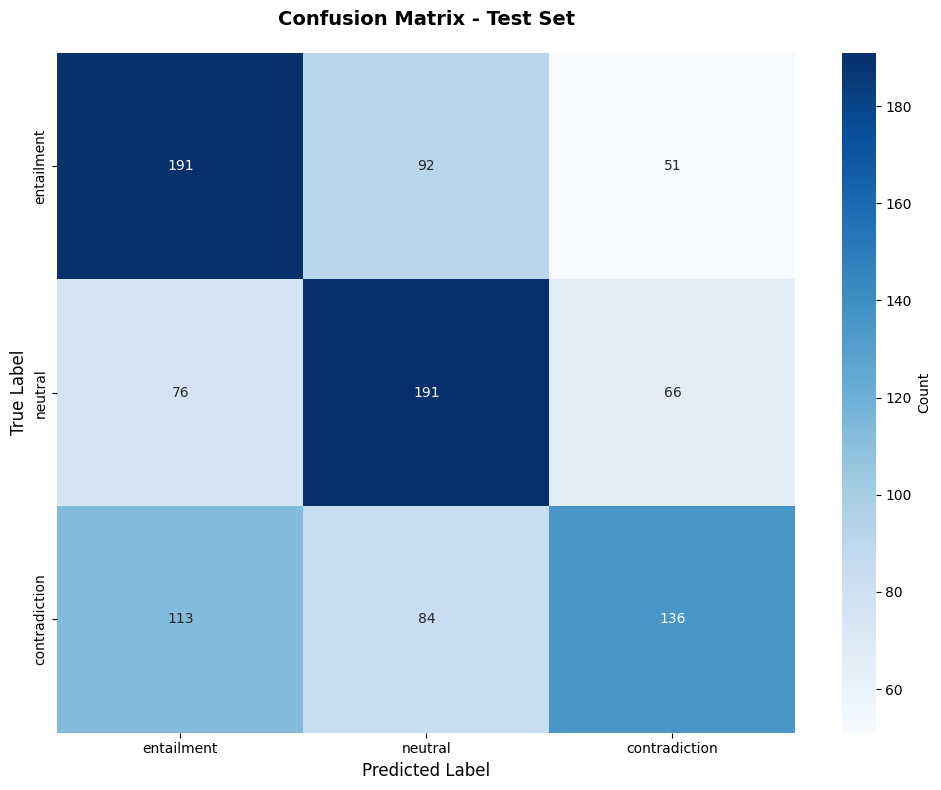

In [43]:
# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['entailment', 'neutral', 'contradiction'],
            yticklabels=['entailment', 'neutral', 'contradiction'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

In [44]:
# Save confusion matrix image
plt.savefig('./visualizations_TF/confusion_matrix.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

## ERROR ANALYSIS

In [45]:
# Identify misclassified examples
test_df_copy = test_df.copy()
test_df_copy['predicted'] = pred_labels
test_df_copy['correct'] = test_df_copy['label'] == test_df_copy['predicted']

errors = test_df_copy[~test_df_copy['correct']]
print(f"\nTotal errors: {len(errors)} / {len(test_df_copy)} ({len(errors)/len(test_df_copy)*100:.2f}%)")


Total errors: 482 / 1000 (48.20%)


In [46]:
# Error breakdown by true class
for label in [0, 1, 2]:
    errors_for_class = errors[errors['label'] == label]
    total_for_class = len(test_df_copy[test_df_copy['label'] == label])
    error_rate = len(errors_for_class) / total_for_class * 100
    print(f"{label_map[label].capitalize():15} {len(errors_for_class):3} / {total_for_class:4} ({error_rate:5.2f}%)")

Entailment      143 /  334 (42.81%)
Neutral         142 /  333 (42.64%)
Contradiction   197 /  333 (59.16%)


In [47]:
# Show challenging examples
for i, (idx, row) in enumerate(errors.head(5).iterrows()):
    print(f"\nExample {i+1}:")
    print(f"Premise: {row['premise']}")
    print(f"Hypothesis: {row['hypothesis']}")
    print(f"True: {label_map[row['label']]} | Predicted: {label_map[row['predicted']]}")


Example 1:
Premise: "Look at Me (When I Rock Wichoo)" is a song by American indie rock band Black Kids, taken from their debut album "Partie Traumatic". It was released in the UK by Almost Gold Recordings on September 8, 2008 and debuted on the Top 200 UK Singles Chart at number 175.
Hypothesis: The song was released in America in September 2008
True: neutral | Predicted: contradiction

Example 2:
Premise: Things Happen at Night is a 1947 British supernatural ghost comedy film directed by Francis Searle and starring Gordon Harker, Alfred Drayton, Robertson Hare and Gwynneth Vaughan. The film is based upon a stage play, "The Poltergeist", by Frank Harvey Jnr.
Hypothesis: Frank Harvey Jnr. wrote Things Happen at Night .
True: contradiction | Predicted: neutral

Example 3:
Premise: Public Domain Day is an observance of when copyrights expire and works enter into the public domain. This legal transition of copyright works into the public domain usually happens every year on 1 January base

## SAVING MODEL

In [48]:
# Save model and tokenizer
output_dir = "./anli_model_TF"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('./anli_model_TF/tokenizer_config.json',
 './anli_model_TF/special_tokens_map.json',
 './anli_model_TF/spm.model',
 './anli_model_TF/added_tokens.json',
 './anli_model_TF/tokenizer.json')

## INFERENCE

In [49]:
def predict_nli(premise, hypothesis):
    """
    Predict NLI relationship between premise and hypothesis.
    """
    device = next(model.parameters()).device
    
    inputs = tokenizer(
        premise, 
        hypothesis,
        return_tensors='pt',
        truncation=True,
        max_length=MAX_LENGTH,
        padding='max_length'
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
    
    return {
        'prediction': label_map[predicted_class],
        'confidence': probabilities[0][predicted_class].item(),
        'probabilities': {
            label_map[i]: probabilities[0][i].item() 
            for i in range(3)
        }
    }

In [50]:
# Test inference
premise = "A woman is walking her dog in the park."
hypothesis = "A person is outdoors with an animal."
result = predict_nli(premise, hypothesis)

In [51]:
print(f"\nPremise: {premise}")
print(f"Hypothesis: {hypothesis}")
print(f"\nPrediction: {result['prediction'].upper()}")
print(f"Confidence: {result['confidence']:.2%}")
print("\nAll Probabilities:")
for label, prob in result['probabilities'].items():
    print(f"  {label.capitalize():15} {prob:.2%}")


Premise: A woman is walking her dog in the park.
Hypothesis: A person is outdoors with an animal.

Prediction: ENTAILMENT
Confidence: 100.00%

All Probabilities:
  Entailment      100.00%
  Neutral         0.00%
  Contradiction   0.00%


In [52]:
print(f"  Test Accuracy: {test_results['eval_accuracy']:.2%}")
print(f"  Test F1 (Macro): {test_results['eval_f1_macro']:.2%}")

  Test Accuracy: 51.80%
  Test F1 (Macro): 51.50%
